In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate
import imageio
import os

# Reload the CSV and snippet data
data_file_path = "/home/gui/SnippetFinder/RSS_algo/time_cuts/data_2024-02-17_23-00-00.csv"
snippet_file_path = "/home/gui/SnippetFinder/area_de_cobertura/default_res/data_2024-02-17_23-00-00.csv/snippet_hr_0.npy"

# Read the CSV file
time_series_data = pd.read_csv(data_file_path)
time_series_data = time_series_data[8000:16000]
snippet = np.load(snippet_file_path)



# Extract the relevant series from the dataset (heart rate data)
heart_rate = time_series_data["HEART_RATE(bpm)"].values
timestamps = pd.to_datetime(time_series_data["timestamp"], unit='ms')

# Correlate snippet with heart rate series
correlation = correlate(heart_rate, snippet, mode='valid')
threshold = 0.97 * np.max(correlation)  # Adjust threshold as needed
matches = np.where(correlation >= threshold)[0]

# Combine close matches into continuous intervals
continuous_intervals = []
if len(matches) > 0:
    current_start = matches[0]
    current_end = current_start + len(snippet)
    for idx in matches[1:]:
        if idx <= current_end:  # Overlapping or adjacent match
            current_end = idx + len(snippet)
        else:
            continuous_intervals.append((current_start, current_end))
            current_start = idx
            current_end = idx + len(snippet)
    continuous_intervals.append((current_start, current_end))

# Limit to 20 evenly spaced intervals for visualization
if len(continuous_intervals) > 50:
    step = len(continuous_intervals) // 50
    continuous_intervals = continuous_intervals[::step]

# Create a directory to save the images
output_dir = "frames"
os.makedirs(output_dir, exist_ok=True)

# Generate and save frames
for i, interval in enumerate(continuous_intervals, start=1):
    plt.figure(figsize=(15, 6))

    # Plot the full time series with highlighted matches up to the current interval
    plt.plot(timestamps, heart_rate, label='Heart Rate Series', color='blue')
    for start, end in continuous_intervals[:i]:  # Highlight intervals up to the current one
        plt.axvspan(timestamps.iloc[start], timestamps.iloc[end - 1], color='red', alpha=0.3, label='Snippet Match')
    plt.xlabel('Time')
    plt.ylabel('Heart Rate (bpm)')
    plt.title(f'Heart Rate Series with Snippet Matches (Step {i})')
    if i == 1:  # Add legend only in the first frame
        plt.legend(loc='upper right')

    plt.tight_layout()

    # Save the current frame
    frame_path = os.path.join(output_dir, f"frame_{i:03d}.png")
    plt.savefig(frame_path)
    plt.close()

# Generate GIF from the saved frames
gif_path = "heart_rate_matches.gif"
with imageio.get_writer(gif_path, mode='I', duration=0.9) as writer:
    for frame_file in sorted(os.listdir(output_dir)):
        if frame_file.endswith(".png"):
            frame_path = os.path.join(output_dir, frame_file)
            writer.append_data(imageio.imread(frame_path))

print(f"GIF saved as {gif_path}")


hr: [81. 81. 81. ... 83. 83. 83.]
ts: 8000    2024-02-18 02:08:58.133
8001    2024-02-18 02:08:58.142
8002    2024-02-18 02:08:58.151
8003    2024-02-18 02:08:58.160
8004    2024-02-18 02:08:58.169
                  ...          
15995   2024-02-18 02:16:08.179
15996   2024-02-18 02:16:08.188
15997   2024-02-18 02:16:08.197
15998   2024-02-18 02:16:08.206
15999   2024-02-18 02:16:08.215
Name: timestamp, Length: 8000, dtype: datetime64[ns]
GIF saved as heart_rate_matches.gif


/tmp/ipykernel_9325/3084423887.py:79: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(frame_path))


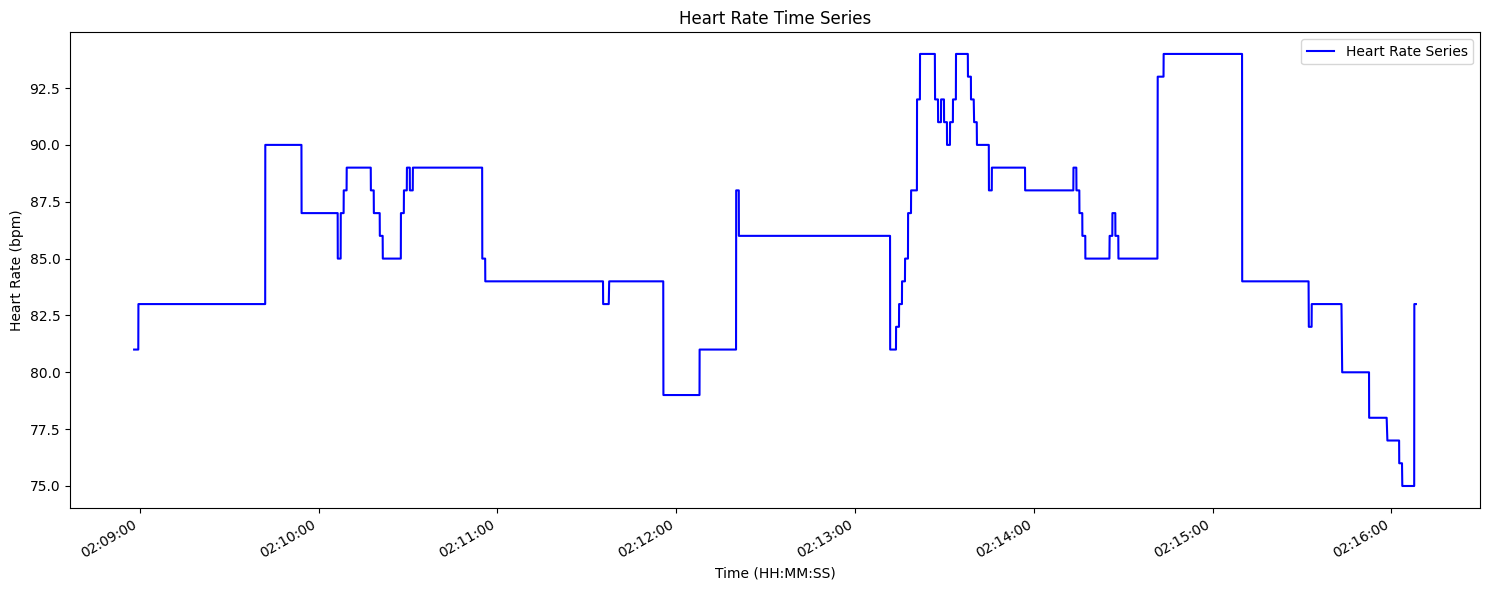

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Plotar a série temporal
plt.figure(figsize=(15, 6))
plt.plot(timestamps, heart_rate, label="Heart Rate Series", color="blue")

# Formatando o eixo x para exibir horários/minutos
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))  # Formato de horas:minutos:segundos
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Ajusta automaticamente os intervalos

# Rotacionar os rótulos do eixo x para melhorar a legibilidade
plt.gcf().autofmt_xdate()

# Adicionar rótulos e título
plt.xlabel("Time (HH:MM:SS)")
plt.ylabel("Heart Rate (bpm)")
plt.title("Heart Rate Time Series")
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()


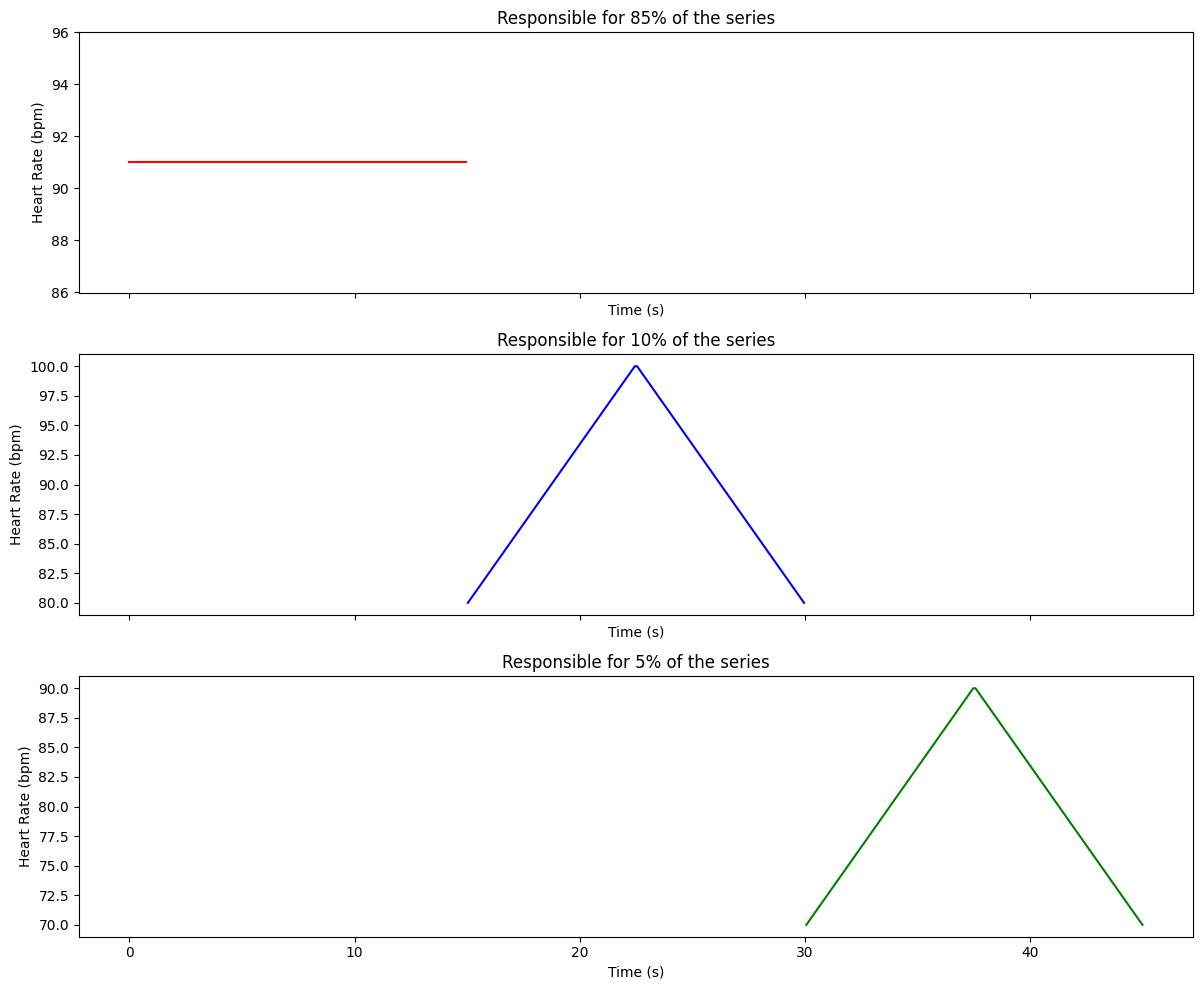

In [ ]:
# Configuração dos parâmetros do gráfico
total_time = 45  # Tempo total: 3 snippets de 15 segundos cada
heart_rate_value = 91  # Valor constante para o primeiro snippet
snippet_duration = 15  # Duração de cada snippet em segundos

# Geração de dados
time_values = np.linspace(0, total_time, total_time * 10)  # 10 pontos por segundo
series = np.zeros_like(time_values)  # Série inicializada com zeros

# Primeiro snippet (constante, 15 segundos)
start_1 = 0
end_1 = snippet_duration * 10  # 15 segundos * 10 pontos por segundo
series[start_1:end_1] = heart_rate_value

# Segundo snippet (transições lineares, 15 segundos)
start_2 = start_1
end_2 = start_2 + snippet_duration * 10
series[start_2:end_2] = np.concatenate([
    np.linspace(80, 100, (end_2 - start_2) // 2),  # Subida linear
    np.linspace(100, 80, (end_2 - start_2) // 2)   # Descida linear
])

# Terceiro snippet (transições lineares, 15 segundos)
start_3 = start_1
end_3 = start_3 + snippet_duration * 10
series[start_3:end_3] = np.concatenate([
    np.linspace(70, 90, (end_3 - start_3) // 2),  # Subida linear
    np.linspace(90, 70, (end_3 - start_3) // 2)   # Descida linear
])

# Plotagem
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Primeiro snippet
axes[0].plot(time_values[start_1:end_1], series[start_1:end_1], color='red')
axes[0].set_title("Responsible for 85% of the series")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Heart Rate (bpm)")

# Segundo snippet
axes[1].plot(time_values[start_2:end_2], series[start_2:end_2], color='blue')
axes[1].set_title("Responsible for 10% of the series")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Heart Rate (bpm)")

# Terceiro snippet
axes[2].plot(time_values[start_3:end_3], series[start_3:end_3], color='green')
axes[2].set_title("Responsible for 5% of the series")
axes[2].set_xlabel("Time (s)")
axes[2].set_ylabel("Heart Rate (bpm)")

# Ajuste final e exibição
plt.tight_layout()
plt.show()
